In [1]:
### Load necessary libraries ###
import glob
import os
import sys
import logging

import librosa
import librosa.display

import numpy as np
from numpy import size

import matplotlib.pyplot as plt
from matplotlib.pyplot import text, legend

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

import tensorflow as tf
from tensorflow import keras

from IPython.display import Audio

# Defs: Global Configuration variables

In [2]:
# Debug and test variables
# Do not process all the sound in the dataset (for faster execution during script development)
REDUCED_MODE = 0
# Number of dataset sounds per folder to process in the reduced-mode.
REDUCED_MODE_SOUNDNUM = 20

# sound processing variables
SOUND_SR = 44100  # sound sampling in Hertz
SOUND_F_FFT = 2048  # Samples per FFT window
SOUND_HOP_LEN = 512 # Hop Length
SOUND_N_MELS = 25 # Number of mel frequencies to analyze

SOUNDSEG_SIZE = 41  # windows per subsound / segment
SOUNDSEG_OVERLAP = 0.4  # 40% overlapping factor for engine sounds

SOUNDSEG_OVERSAMPLING = 4  # how many times to increase the engine category samples
SOUNDSEG_CLASS2OVERSAMPLE = 5  # Oversample the engine class (num. 5)

# Preprocessing
PREPROC_SKIP = 0  # Skip preprocessing files and use previosuly saved '.npz'

# CNN Processing
CNN_EPOCHS = 18
CNN_LEAKYRELU = 1
CNN_BATCHSIZE = 32
CNN_KERNELSIZE = (3,3)
CNN_POOLSIZE = (2,2)

# Paths and folders
soundsPath = 'UrbanSounds8K/1_audioFiles/'
soundsSubPaths = np.array(['fold1', 'fold2', 'fold3', 'fold4',
                          'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10'])
preProcPath = "UrbanSounds8K/2_featuresProcessed/"
trainingResultsPath = "UrbanSounds8K/3_trainingResults/"
confusionFile = "confusion_matrix"
trainingFile = "trainingResults"
logPath = "UrbanSounds8k/4_executionLog/"


In [3]:
# Setup logging both in console and file
if not 'procLog' in vars():
    sHand = logging.StreamHandler();
    procLog = logging.getLogger('PreProc')
    logging.basicConfig(level = logging.INFO,
     filename = logPath + 'executionLog.log',
      filemode = 'w', format = '%(asctime)s :: %(message)s',
      datefmt='%d-%b-%y %H:%M:%S');
    procLog.addHandler(sHand);


# Defs: Preprocessing and feature extraction from audios

In [4]:
# Divide an sound file into shorter and overlapped parts.
def soundSegmentation(soundSignal, subsoundSize, overlapFactor=SOUNDSEG_OVERLAP):
    start = 0
    while start < len(soundSignal):
        yield int(start), int(start + subsoundSize)
        start += (subsoundSize // (1/(1-overlapFactor)))

# Add white noise to signal respecting a maximum amplitude based on RMS energy of the original signal
def soundAddGaussianNoise(soundSignal, sampleRate = SOUND_SR, maxAmplitude_percRMS = 0.1):
    signalRMS = (np.average(soundSignal**2))**(1/2);
    
    randomFact1 = np.random.rand(1);
    randomFact2 = np.random.rand(1);

    factMax =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 > randomFact2 else randomFact2);
    factMin =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 < randomFact2 else randomFact2);

    transform = AddGaussianNoise(min_amplitude=factMin, max_amplitude=factMax,p=1);
    augSoundSignal = transform(soundSignal,sample_rate=44100);

    return augSoundSignal

# Load sound with Librosa and make it faster or slower (time stretching)
def soundLoadAndStretch(soundPath, sampleRate = SOUND_SR, maxStretch = 0.1):
    randomFact = (np.random.rand(1) - 0.5) * maxStretch;
    soundSignal, sr = librosa.load(soundPath, sr=SOUND_SR * (1+maxStretch));
    return soundSignal;

In [5]:
# Extract features from sound files, generating spectogram segments (images)
def extractSoundFeature(soundsPath, soundsSubPath, n_mels=SOUND_N_MELS, n_windows=SOUNDSEG_SIZE, hopLength=SOUND_HOP_LEN,
                        soundOversamplingFact=SOUNDSEG_OVERSAMPLING, soundOverClass=SOUNDSEG_CLASS2OVERSAMPLE):

    subsoundSize = hopLength * (n_windows - 1)
    features_AM, origClasses_A, segSounds_AA = [], [], []

    # Map all sound samples paths inside the folder
    allsoundsPath_A = glob.glob(os.path.join(
        soundsPath, soundsSubPath, "*.wav"))

    # Iterate and extract features from each sound
    idxSound, idxSegment = 0, 0
    for soundPath in allsoundsPath_A:
        idxSound = idxSound+1
        # Early stop for reduced mode
        if REDUCED_MODE == 1 and idxSound == REDUCED_MODE_SOUNDNUM:
            break

        # Extract sound class by parsing file name
        soundClass = int(soundPath.split('/')[2].split('-')[1])

        # Loop more than once in the same sound (oversampling) if is engine class (5)
        if soundClass == soundOverClass:
            maxRepeatOverSampl = soundOversamplingFact  # Oversampling by repetition
            overlapFactor = SOUNDSEG_OVERLAP  # Oversampling by overlapping
        else:
            maxRepeatOverSampl = 1
            overlapFactor = 0

        idxOverSampl = 0
        for idxOverSampl in np.arange(maxRepeatOverSampl):

            # Extract '.wav' sound to an 1-D array and apply stretching if required
            if idxOverSampl > 0:
                soungSignal_A = soundLoadAndStretch(
                    soundPath, SOUND_SR, 0.1)  # stretch
            else:
                soungSignal_A = soundLoadAndStretch(
                    soundPath, SOUND_SR, 0.0)  # don't stretch

            # Create subsegments from sound file and extract the features
            segSoundSignal_AA, segSoundSpect_AM, segSoundClass_A = [], [], []  # Init arrays
            for (start, end) in soundSegmentation(soungSignal_A, subsoundSize, overlapFactor):
                if (len(soungSignal_A[start:end]) == subsoundSize):
                    idxSegment = idxSegment+1

                    # Append sound class to segments class array
                    segSoundClass_A.append(soundClass)

                    # Extract segment from sound data - 1D Array
                    segSoundSignal_A = soungSignal_A[start:end]
                    segSoundSignal_AA.append(segSoundSignal_A)  # All segs. array

                    # Apply data augmentation if repeated loop
                    if idxOverSampl > 0:
                        segSoundSignal_A = soundAddGaussianNoise(segSoundSignal_A, SOUND_SR, 0.1)

                    # Transform to spectogram in decibels - 2D Matrix
                    segsoundSpect_M = librosa.feature.mfcc(y=segSoundSignal_A, n_mfcc=n_mels)
                    #segsoundSpect_M = librosa.feature.melspectrogram(y=segSoundSignal_A, n_mels=n_mels)
                    #segsoundSpect_M = librosa.amplitude_to_db(segsoundSpect_M)

                    # Reshape and append to preprocessed spectograms
                    segsoundSpect_M = segsoundSpect_M.T.flatten()[:, np.newaxis].T
                    segSoundSpect_AM.append(segsoundSpect_M)

            segSoundSpect_AM = np.asarray(segSoundSpect_AM).reshape(len(segSoundSpect_AM), n_mels, n_windows, 1)

            # If last sound not empty, stack together with others
            if len(segSoundSpect_AM) > 0:
                segSounds_AA.append(segSoundSignal_AA)
                features_AM.append(segSoundSpect_AM)
                origClasses_A.append(segSoundClass_A)
    
    procLog.log(msg = '-> Num of segments for '+ soundsSubPath +' -> ' + str(idxSegment) + 
                ' - out of - ' + str(idxSound) + ' sounds.', level=20)

    # Stack all data 'per segment' and not 'per sound'
    segSounds_AA = np.concatenate(segSounds_AA, axis=0)
    features_AM = np.concatenate(features_AM, axis=0)
    origClasses_A = np.concatenate(origClasses_A, axis=0)

    # Convert UrbanSounds8K class to binary 'is/isn't engine'
    engineClasses_A = np.array(
        list(map(lambda x: 1 if x == 5 else 0, origClasses_A)))

    return segSounds_AA, features_AM, engineClasses_A


# Defs: CNN Model

In [6]:
# Define convolutional network architecture ###
def CNN_modelDefinition(useLeakyRelu=0):
    keras.backend.clear_session()

    pool_size = CNN_POOLSIZE
    kernel_size = CNN_KERNELSIZE
    input_shape = (SOUND_N_MELS, SOUNDSEG_SIZE, 1)
    num_classes = 2  

    # ---------- Convolutional + Pooling Layer 1 ---------- #
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same",
              input_shape=input_shape, dilation_rate=1))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Convolutional + Pooling Layer 2 ---------- #
    model.add(keras.layers.Conv2D(80, kernel_size,
              padding="same", dilation_rate=2))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Pooling Layer Layer ---------- #
    model.add(keras.layers.GlobalMaxPooling2D())

    # ---------- Flat Layers ---------- #
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    return model


# Proc: Sound Processing and Features Extraction

-> Num of segments for fold1 -> 11065 - out of - 873 sounds.
-> Num of segments for fold2 -> 11217 - out of - 888 sounds.
-> Num of segments for fold3 -> 11965 - out of - 925 sounds.
-> Num of segments for fold4 -> 12293 - out of - 990 sounds.
-> Num of segments for fold5 -> 11779 - out of - 936 sounds.
-> Num of segments for fold6 -> 11241 - out of - 823 sounds.
-> Num of segments for fold7 -> 11337 - out of - 838 sounds.
-> Num of segments for fold8 -> 9878 - out of - 806 sounds.
-> Num of segments for fold9 -> 10373 - out of - 816 sounds.
-> Num of segments for fold10 -> 10615 - out of - 837 sounds.


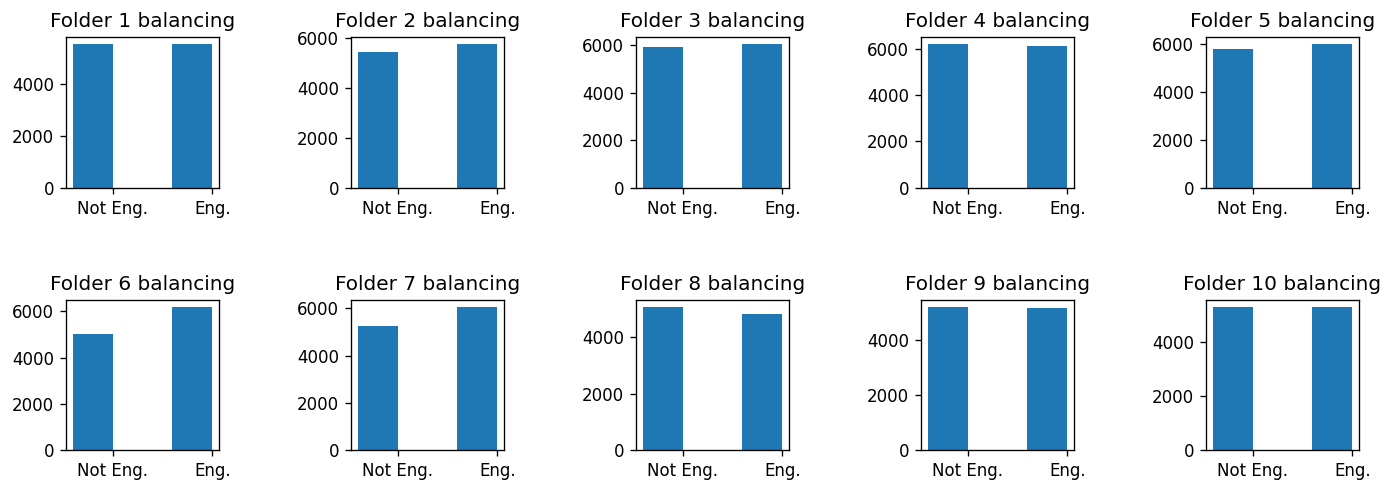

In [7]:
# Pre-process and extract feature from the data
if PREPROC_SKIP == 0:
    fig, axes = plt.subplots(2, 5, dpi=120)
    axes = axes.ravel()
    fig.set_figheight(10*0.5)
    fig.set_figwidth(25*0.5)
    fig.tight_layout(pad=4.5)

    # Loop through all sound folders
    idxFold = 0
    for soundSubPath in soundsSubPaths:
        # Extract files from folder and save externally for reuse
        segSounds_AA, features_AM, classes_A = extractSoundFeature(soundsPath, soundSubPath)
        np.savez("{0}{1}".format(preProcPath, soundSubPath),
                 segSounds = segSounds_AA, features=features_AM, classes=classes_A)

        # Plot histogram of data balancing per folder
        axes[idxFold].set_title('Folder ' + str(idxFold+1) + ' balancing')
        tmpData = np.asarray(classes_A)
        tmpData = [np.count_nonzero(tmpData == 0),
                   np.count_nonzero(tmpData == 1)]
        axes[idxFold].bar(['Not Eng.', 'Eng.'], tmpData,
                          align='edge', width=-0.4, label="Train")
        idxFold += 1
    fig.savefig(fname = logPath + '1_foldersProcessing.jpg' );
        

# Proc:  CNN Training and Testing

In [8]:
### Train and evaluate via 10-soundsSubPaths cross-validation ###
kf = KFold(n_splits=10)

# List containing all confusion matrix for all K-Fold Train-Test.
# Array containing the results of the training for each train/test set.
allConfusionMatrix_AM, allFitResults_A = [], []

# Loop to train-test in all folder combinations.
idx = 0
for train_index, test_index in kf.split(soundsSubPaths):
    idx = idx+1

    #print('--> Starting a loop! - Folder ', idx)
    procLog.info('----------> PROC: Starting a loop! - Folder ' + str(idx)+ ' <----------');
    x_train, y_train = [], []

    # ---------------- STEP 1 ----------------
    # Load training data from 9 out of 10 folders
    # Loop through all training folders and gather data in single feature array
    for idxTrainFolder in train_index:
        #print('-> Getting data from TRAINING folder ', idxTrainFolder+1)
        procLog.info('-> Getting data from TRAINING folder ' +  str(idxTrainFolder+1))
        # Read pre-saved features or segments of an sound file (pre-processed)
        train_data = np.load("{0}/{1}.npz".format(preProcPath, soundsSubPaths[idxTrainFolder]), allow_pickle=True);

        # Append all the 'features' and 'classes' train datasets
        # in a single list containing all train folders data
        x_train.append(train_data["features"]);
        y_train.append(train_data["classes"]);

    # Stack all the folders in a single X/Y dataset
    x_train = np.concatenate(x_train, axis=0).astype(np.float32);
    y_train = np.concatenate(y_train, axis=0).astype(np.float32);
    procLog.info('-> TRAIN dataset size: ' + str(len(x_train)))
    #print('-> TRAIN dataset size: ', len(x_train))

    # ---------------- STEP 2 ----------------
    # Load test data from 1 out of 10 folders
    #print('\n-> Getting data from TESTING folder ', test_index+1)
    procLog.info('-> Getting data from TESTING folder ' + str(test_index+1))
    test_data = np.load("{0}/{1}.npz".format(preProcPath, soundsSubPaths[test_index][0]), allow_pickle=True)
    x_test, y_test = test_data["features"], test_data["classes"];
    #print('-> TEST dataset size: ', len(x_test))
    procLog.info('-> TEST dataset size: ' + str(len(x_test)))

    CNN_model = CNN_modelDefinition(useLeakyRelu=CNN_LEAKYRELU)

    #print('\n--> Fitting model!');
    procLog.info('-> Fitting model!');
    allFitResults_A.append(CNN_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=CNN_EPOCHS, batch_size=CNN_BATCHSIZE, verbose=1));
    procLog.info('-> Accuracy:' + str(allFitResults_A[-1].history["accuracy"][-1]));
    procLog.info('-> Val. Accuracy:' + str(allFitResults_A[-1].history["val_accuracy"][-1]));
    procLog.info('-> Loss:' + str(allFitResults_A[-1].history["loss"][-1]));
    procLog.info('-> Val. Loss:' + str(allFitResults_A[-1].history["val_loss"][-1]));

    # Predict results from test data
    y_test_pred = []
    y_test_pred = CNN_model.predict(x_test)  # Categorical results
    y_test_pred = np.asarray(tf.argmax(y_test_pred, axis=1))  # OHE to Category

    # Append the confusion matrix of this K-Fold run to a matrix list
    allConfusionMatrix_AM.append(confusion_matrix(y_test, y_test_pred, normalize='true'))

    # Early stop for reduced mode
    if REDUCED_MODE == 1:
        break

# Save the resulting confusion matrices and training data
np.savez("{0}{1}".format(trainingResultsPath, confusionFile), allConfusionMatrix_AM=allConfusionMatrix_AM);
np.savez("{0}{1}".format(trainingResultsPath, trainingFile), allFitResults_A=allFitResults_A);


----------> PROC: Starting a loop! - Folder 1 <----------
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 100698
-> Getting data from TESTING folder [1]
-> TEST dataset size: 11065
-> Fitting model!


Epoch 1/12
3147/3147 [==============================] - 158s 50ms/step - loss: 0.3585 - accuracy: 0.8407 - val_loss: 0.7482 - val_accuracy: 0.7241
Epoch 2/12
3147/3147 [==============================] - 158s 50ms/step - loss: 0.2939 - accuracy: 0.8697 - val_loss: 0.7450 - val_accuracy: 0.6856
Epoch 3/12
3147/3147 [==============================] - 157s 50ms/step - loss: 0.2593 - accuracy: 0.8866 - val_loss: 0.7251 - val_accuracy: 0.7246
Epoch 4/12
3147/3147 [==============================] - 158s 50ms/step - loss: 0.2293 - accuracy: 0.9012 - val_loss: 0.6721 - val_accuracy: 0.7858
Epoch 5/12
3147/3147 [==============================] - 157s 50ms/step - loss: 0.2075 - accuracy: 0.9117 - val_loss: 0.5961 - val_accuracy: 0.8120
Epoch 6/12
3147/3147 [==============================] - 158s 50ms/step - loss: 0.1916 - accuracy: 0.9189 - val_loss: 0.5833 - val_accuracy: 0.8232
Epoch 7/12
3147/3147 [==============================] - 161s 51ms/step - loss: 0.1785 - accuracy: 0.9269 - val_loss: 0

-> Accuracy:0.9478241801261902
-> Val. Accuracy:0.8416628837585449
-> Loss:0.1325158178806305
-> Val. Loss:0.5999106168746948
----------> PROC: Starting a loop! - Folder 2 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 100546
-> Getting data from TESTING folder [2]
-> TEST dataset size: 11217
-> Fitting model!


Epoch 1/12
3143/3143 [==============================] - 156s 50ms/step - loss: 0.3790 - accuracy: 0.8339 - val_loss: 0.6761 - val_accuracy: 0.6441
Epoch 2/12
3143/3143 [==============================] - 156s 49ms/step - loss: 0.2912 - accuracy: 0.8736 - val_loss: 0.5847 - val_accuracy: 0.6856
Epoch 3/12
3143/3143 [==============================] - 156s 50ms/step - loss: 0.2379 - accuracy: 0.8997 - val_loss: 0.5111 - val_accuracy: 0.7638
Epoch 4/12
3143/3143 [==============================] - 157s 50ms/step - loss: 0.2048 - accuracy: 0.9156 - val_loss: 0.4988 - val_accuracy: 0.7753
Epoch 5/12
3143/3143 [==============================] - 156s 50ms/step - loss: 0.1845 - accuracy: 0.9246 - val_loss: 0.5299 - val_accuracy: 0.7804
Epoch 6/12
3143/3143 [==============================] - 156s 50ms/step - loss: 0.1696 - accuracy: 0.9326 - val_loss: 0.5455 - val_accuracy: 0.7665
Epoch 7/12
3143/3143 [==============================] - 157s 50ms/step - loss: 0.1567 - accuracy: 0.9386 - val_loss: 0

-> Accuracy:0.9545382261276245
-> Val. Accuracy:0.8248194456100464
-> Loss:0.11773071438074112
-> Val. Loss:0.4284781813621521
----------> PROC: Starting a loop! - Folder 3 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 99798
-> Getting data from TESTING folder [3]
-> TEST dataset size: 11965
-> Fitting model!


Epoch 1/12
3119/3119 [==============================] - 156s 50ms/step - loss: 0.3725 - accuracy: 0.8333 - val_loss: 0.6092 - val_accuracy: 0.7157
Epoch 2/12
3119/3119 [==============================] - 154s 49ms/step - loss: 0.2926 - accuracy: 0.8709 - val_loss: 0.6914 - val_accuracy: 0.6893
Epoch 3/12
3119/3119 [==============================] - 157s 50ms/step - loss: 0.2405 - accuracy: 0.8957 - val_loss: 0.5446 - val_accuracy: 0.8001
Epoch 4/12
3119/3119 [==============================] - 155s 50ms/step - loss: 0.2103 - accuracy: 0.9109 - val_loss: 0.6153 - val_accuracy: 0.7256
Epoch 5/12
3119/3119 [==============================] - 155s 50ms/step - loss: 0.1880 - accuracy: 0.9230 - val_loss: 0.5214 - val_accuracy: 0.8038
Epoch 6/12
3119/3119 [==============================] - 155s 50ms/step - loss: 0.1720 - accuracy: 0.9304 - val_loss: 0.5240 - val_accuracy: 0.7816
Epoch 7/12
3119/3119 [==============================] - 156s 50ms/step - loss: 0.1556 - accuracy: 0.9380 - val_loss: 0

-> Accuracy:0.954678475856781
-> Val. Accuracy:0.8274968862533569
-> Loss:0.11751378327608109
-> Val. Loss:0.603287935256958
----------> PROC: Starting a loop! - Folder 4 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 99470
-> Getting data from TESTING folder [4]
-> TEST dataset size: 12293
-> Fitting model!


Epoch 1/12
3109/3109 [==============================] - 156s 50ms/step - loss: 0.3716 - accuracy: 0.8321 - val_loss: 0.4451 - val_accuracy: 0.7597
Epoch 2/12
3109/3109 [==============================] - 153s 49ms/step - loss: 0.2910 - accuracy: 0.8726 - val_loss: 0.4018 - val_accuracy: 0.8236
Epoch 3/12
3109/3109 [==============================] - 153s 49ms/step - loss: 0.2409 - accuracy: 0.8964 - val_loss: 0.4793 - val_accuracy: 0.7543
Epoch 4/12
3109/3109 [==============================] - 154s 50ms/step - loss: 0.2110 - accuracy: 0.9119 - val_loss: 0.5533 - val_accuracy: 0.7222
Epoch 5/12
3109/3109 [==============================] - 154s 49ms/step - loss: 0.1923 - accuracy: 0.9212 - val_loss: 0.5211 - val_accuracy: 0.7752
Epoch 6/12
3109/3109 [==============================] - 154s 50ms/step - loss: 0.1761 - accuracy: 0.9281 - val_loss: 0.5606 - val_accuracy: 0.7780
Epoch 7/12
3109/3109 [==============================] - 154s 50ms/step - loss: 0.1652 - accuracy: 0.9341 - val_loss: 0

-> Accuracy:0.9517945051193237
-> Val. Accuracy:0.7272431254386902
-> Loss:0.12291743606328964
-> Val. Loss:0.7140108942985535
----------> PROC: Starting a loop! - Folder 5 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 99984
-> Getting data from TESTING folder [5]
-> TEST dataset size: 11779
-> Fitting model!


Epoch 1/12
3125/3125 [==============================] - 155s 49ms/step - loss: 0.3834 - accuracy: 0.8282 - val_loss: 0.4378 - val_accuracy: 0.8275
Epoch 2/12
3125/3125 [==============================] - 158s 50ms/step - loss: 0.2960 - accuracy: 0.8689 - val_loss: 0.4902 - val_accuracy: 0.8314
Epoch 3/12
3125/3125 [==============================] - 155s 50ms/step - loss: 0.2487 - accuracy: 0.8923 - val_loss: 0.5010 - val_accuracy: 0.8298
Epoch 4/12
3125/3125 [==============================] - 156s 50ms/step - loss: 0.2175 - accuracy: 0.9080 - val_loss: 0.4724 - val_accuracy: 0.8231
Epoch 5/12
3125/3125 [==============================] - 155s 50ms/step - loss: 0.1989 - accuracy: 0.9182 - val_loss: 0.4181 - val_accuracy: 0.8253
Epoch 6/12
3125/3125 [==============================] - 156s 50ms/step - loss: 0.1798 - accuracy: 0.9274 - val_loss: 0.5943 - val_accuracy: 0.8486
Epoch 7/12
3125/3125 [==============================] - 156s 50ms/step - loss: 0.1658 - accuracy: 0.9344 - val_loss: 0

-> Accuracy:0.9525123834609985
-> Val. Accuracy:0.8196790814399719
-> Loss:0.12557722628116608
-> Val. Loss:0.5254628658294678
----------> PROC: Starting a loop! - Folder 6 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 100522
-> Getting data from TESTING folder [6]
-> TEST dataset size: 11241
-> Fitting model!


Epoch 1/12
3142/3142 [==============================] - 156s 49ms/step - loss: 0.3754 - accuracy: 0.8332 - val_loss: 0.3653 - val_accuracy: 0.8330
Epoch 2/12
3142/3142 [==============================] - 154s 49ms/step - loss: 0.2829 - accuracy: 0.8763 - val_loss: 0.3954 - val_accuracy: 0.8049
Epoch 3/12
3142/3142 [==============================] - 156s 50ms/step - loss: 0.2318 - accuracy: 0.9010 - val_loss: 0.3675 - val_accuracy: 0.8327
Epoch 4/12
3142/3142 [==============================] - 155s 49ms/step - loss: 0.2035 - accuracy: 0.9156 - val_loss: 0.3498 - val_accuracy: 0.8504
Epoch 5/12
3142/3142 [==============================] - 155s 49ms/step - loss: 0.1808 - accuracy: 0.9266 - val_loss: 0.4003 - val_accuracy: 0.8235
Epoch 6/12
3142/3142 [==============================] - 155s 49ms/step - loss: 0.1682 - accuracy: 0.9328 - val_loss: 0.3804 - val_accuracy: 0.8188
Epoch 7/12
3142/3142 [==============================] - 156s 50ms/step - loss: 0.1555 - accuracy: 0.9377 - val_loss: 0

-> Accuracy:0.9551043510437012
-> Val. Accuracy:0.8085579872131348
-> Loss:0.11731907725334167
-> Val. Loss:0.398593008518219
----------> PROC: Starting a loop! - Folder 7 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 100426
-> Getting data from TESTING folder [7]
-> TEST dataset size: 11337
-> Fitting model!


Epoch 1/12
3139/3139 [==============================] - 155s 49ms/step - loss: 0.3737 - accuracy: 0.8322 - val_loss: 0.5077 - val_accuracy: 0.7759
Epoch 2/12
3139/3139 [==============================] - 154s 49ms/step - loss: 0.2903 - accuracy: 0.8723 - val_loss: 0.3990 - val_accuracy: 0.8264
Epoch 3/12
3139/3139 [==============================] - 154s 49ms/step - loss: 0.2385 - accuracy: 0.8984 - val_loss: 0.4204 - val_accuracy: 0.8076
Epoch 4/12
3139/3139 [==============================] - 154s 49ms/step - loss: 0.2063 - accuracy: 0.9138 - val_loss: 0.4031 - val_accuracy: 0.7994
Epoch 5/12
3139/3139 [==============================] - 155s 49ms/step - loss: 0.1815 - accuracy: 0.9262 - val_loss: 0.3889 - val_accuracy: 0.8137
Epoch 6/12
3139/3139 [==============================] - 155s 49ms/step - loss: 0.1691 - accuracy: 0.9322 - val_loss: 0.4410 - val_accuracy: 0.8075
Epoch 7/12
3139/3139 [==============================] - 155s 49ms/step - loss: 0.1552 - accuracy: 0.9388 - val_loss: 0

-> Accuracy:0.9561766982078552
-> Val. Accuracy:0.8048866391181946
-> Loss:0.11655661463737488
-> Val. Loss:0.4993487000465393
----------> PROC: Starting a loop! - Folder 8 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 101885
-> Getting data from TESTING folder [8]
-> TEST dataset size: 9878
-> Fitting model!


Epoch 1/12
3184/3184 [==============================] - 157s 49ms/step - loss: 0.3809 - accuracy: 0.8307 - val_loss: 0.4211 - val_accuracy: 0.8090
Epoch 2/12
3184/3184 [==============================] - 158s 50ms/step - loss: 0.2889 - accuracy: 0.8719 - val_loss: 0.3656 - val_accuracy: 0.8194
Epoch 3/12
3184/3184 [==============================] - 158s 49ms/step - loss: 0.2384 - accuracy: 0.8971 - val_loss: 0.4004 - val_accuracy: 0.8213
Epoch 4/12
3184/3184 [==============================] - 157s 49ms/step - loss: 0.2064 - accuracy: 0.9133 - val_loss: 0.3606 - val_accuracy: 0.8376
Epoch 5/12
3184/3184 [==============================] - 159s 50ms/step - loss: 0.1836 - accuracy: 0.9240 - val_loss: 0.3562 - val_accuracy: 0.8422
Epoch 6/12
3184/3184 [==============================] - 158s 50ms/step - loss: 0.1656 - accuracy: 0.9331 - val_loss: 0.3588 - val_accuracy: 0.8503
Epoch 7/12
3184/3184 [==============================] - 158s 50ms/step - loss: 0.1554 - accuracy: 0.9389 - val_loss: 0

-> Accuracy:0.9563919901847839
-> Val. Accuracy:0.8617128729820251
-> Loss:0.11390983313322067
-> Val. Loss:0.3687177300453186
----------> PROC: Starting a loop! - Folder 9 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 101390
-> Getting data from TESTING folder [9]
-> TEST dataset size: 10373
-> Fitting model!


Epoch 1/12
3169/3169 [==============================] - 156s 49ms/step - loss: 0.3925 - accuracy: 0.8249 - val_loss: 0.3478 - val_accuracy: 0.8072
Epoch 2/12
3169/3169 [==============================] - 156s 49ms/step - loss: 0.3083 - accuracy: 0.8634 - val_loss: 0.2160 - val_accuracy: 0.9131
Epoch 3/12
3169/3169 [==============================] - 155s 49ms/step - loss: 0.2600 - accuracy: 0.8879 - val_loss: 0.1989 - val_accuracy: 0.9091
Epoch 4/12
3169/3169 [==============================] - 156s 49ms/step - loss: 0.2239 - accuracy: 0.9061 - val_loss: 0.2039 - val_accuracy: 0.9001
Epoch 5/12
3169/3169 [==============================] - 156s 49ms/step - loss: 0.1982 - accuracy: 0.9189 - val_loss: 0.1355 - val_accuracy: 0.9401
Epoch 6/12
3169/3169 [==============================] - 156s 49ms/step - loss: 0.1797 - accuracy: 0.9270 - val_loss: 0.1199 - val_accuracy: 0.9574
Epoch 7/12
3169/3169 [==============================] - 156s 49ms/step - loss: 0.1662 - accuracy: 0.9337 - val_loss: 0

-> Accuracy:0.952628493309021
-> Val. Accuracy:0.9584498405456543
-> Loss:0.12306144833564758
-> Val. Loss:0.11912108957767487
----------> PROC: Starting a loop! - Folder 10 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> TRAIN dataset size: 101148
-> Getting data from TESTING folder [10]
-> TEST dataset size: 10615
-> Fitting model!


Epoch 1/12
3161/3161 [==============================] - 158s 50ms/step - loss: 0.3851 - accuracy: 0.8299 - val_loss: 0.3991 - val_accuracy: 0.7927
Epoch 2/12
3161/3161 [==============================] - 153s 48ms/step - loss: 0.3113 - accuracy: 0.8637 - val_loss: 0.3538 - val_accuracy: 0.8217
Epoch 3/12
3161/3161 [==============================] - 152s 48ms/step - loss: 0.2619 - accuracy: 0.8869 - val_loss: 0.3178 - val_accuracy: 0.8441
Epoch 4/12
3161/3161 [==============================] - 152s 48ms/step - loss: 0.2274 - accuracy: 0.9029 - val_loss: 0.2912 - val_accuracy: 0.8454
Epoch 5/12
3161/3161 [==============================] - 153s 49ms/step - loss: 0.2007 - accuracy: 0.9158 - val_loss: 0.3036 - val_accuracy: 0.8537
Epoch 6/12
3161/3161 [==============================] - 154s 49ms/step - loss: 0.1809 - accuracy: 0.9272 - val_loss: 0.2913 - val_accuracy: 0.8486
Epoch 7/12
3161/3161 [==============================] - 154s 49ms/step - loss: 0.1668 - accuracy: 0.9335 - val_loss: 0

-> Accuracy:0.9525052309036255
-> Val. Accuracy:0.8634008765220642
-> Loss:0.12436146289110184
-> Val. Loss:0.3264084458351135


INFO:tensorflow:Assets written to: ram://9aa4176b-a2a4-4360-91cf-04f60ed8face/assets
INFO:tensorflow:Assets written to: ram://3c603d6e-f0fd-4a86-806b-f5f03cfb23c0/assets
INFO:tensorflow:Assets written to: ram://4362e0f0-d37b-4fd0-a9bc-e362ed246516/assets
INFO:tensorflow:Assets written to: ram://eb53c2b9-ae07-47c1-8211-fed283d785ce/assets
INFO:tensorflow:Assets written to: ram://24e53b29-0e2a-493d-a3ed-fa3e7540b35c/assets
INFO:tensorflow:Assets written to: ram://68ea313a-2c03-4124-8b88-8d0e2f1e377d/assets
INFO:tensorflow:Assets written to: ram://a0d2078f-6d1a-49c8-b88c-9d8f598f03fd/assets
INFO:tensorflow:Assets written to: ram://43d4e247-20d0-4b73-8b09-d4587aee7ced/assets
INFO:tensorflow:Assets written to: ram://fc6d8b8a-6a34-491c-a4a8-426a78c81a7d/assets
INFO:tensorflow:Assets written to: ram://87960888-2f79-4c3c-9ebd-8997c77b1f46/assets


Class identifiers according to UrbanSounds 8k :

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

# Analyze: Plot all the confusion matrix + final average

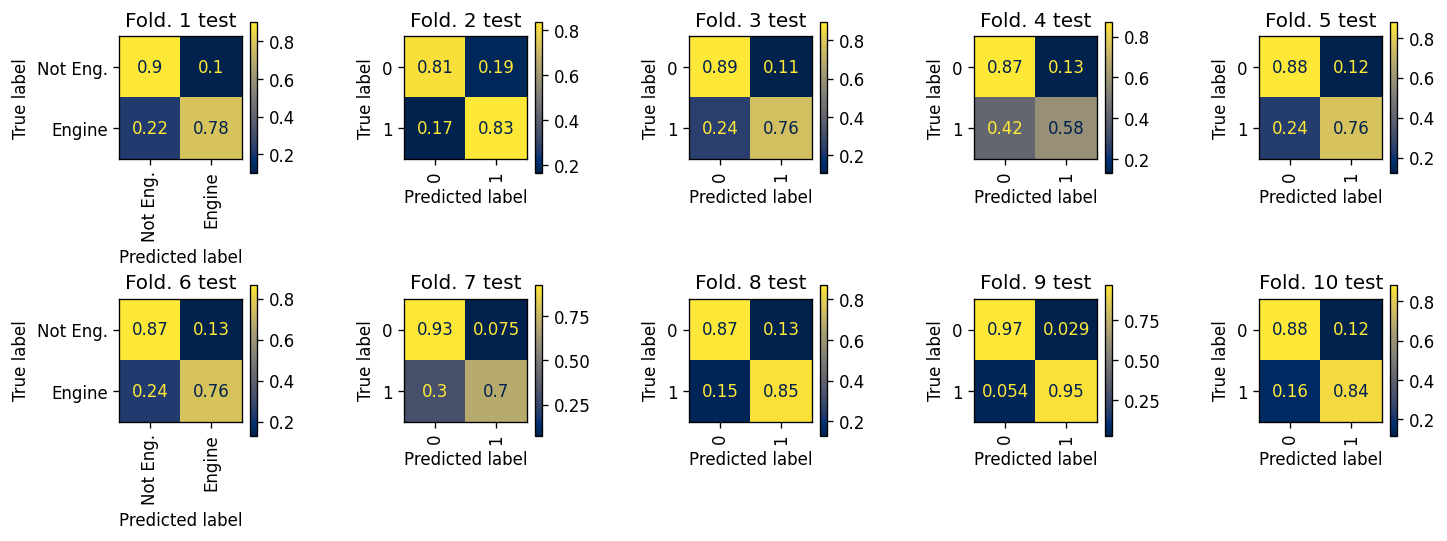

In [9]:
# Load from pre-saved file
allConfusionMatrix_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["allConfusionMatrix_AM"]

# Plot all confusion matrix
fig, axes = plt.subplots(2, 5, dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for cm in allConfusionMatrix_AM:
    axes[idxRow][idxCol].set_title('Fold. ' + str(5*idxRow+idxCol+1) + ' test')
    if idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Eng.', 'Engine'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmPlt = cmDisplay.plot(ax=axes[idxRow][idxCol], cmap='cividis', xticks_rotation='vertical');

    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
    
    fig.savefig(fname = logPath + '2_allConfusionMatrix.jpg' );

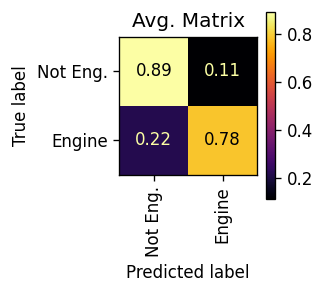

In [10]:
# Average results
confusionMatrixAvg_M = np.zeros([2,2]);
for cm in allConfusionMatrix_AM:
    confusionMatrixAvg_M += cm;
confusionMatrixAvg_M *=0.1;

# Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(2); fig.tight_layout(pad=0.5);

axes.set_title('Avg. Matrix')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixAvg_M, display_labels=['Not Eng.', 'Engine'])
cmDisplay.plot(ax=axes,  cmap='inferno', xticks_rotation='vertical')

fig.savefig(fname = logPath + '3_avgConfusionMatrix.jpg' );

# Analyze: Plot training and testing graphs

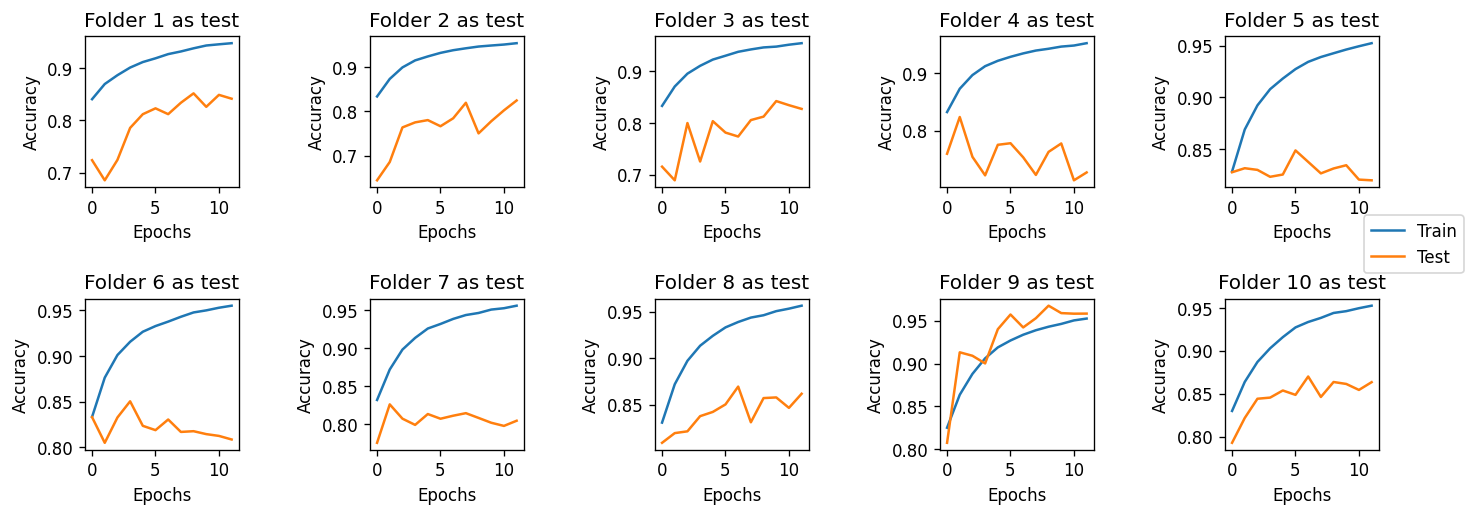

In [11]:
# Plot
fig, axes = plt.subplots(2,5,dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for resPlot in allFitResults_A:
    axes[idxRow][idxCol].set_title('Folder ' + str(5*idxRow+idxCol+1) + ' as test')
    axes[idxRow][idxCol].plot(resPlot.history['accuracy']); 
    axes[idxRow][idxCol].plot(resPlot.history['val_accuracy']);
    axes[idxRow][idxCol].set(ylabel = 'Accuracy', xlabel= 'Epochs');
    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
fig.legend(['Train' , 'Test'], loc=5, bbox_to_anchor=(1, 0.517), fontsize = 'medium');
fig.savefig(fname = logPath + '4_allTrainTestStats.jpg' );


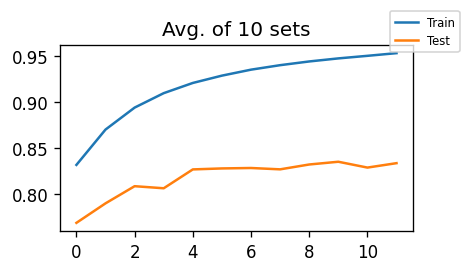

In [12]:
# Average results
avgAcc = np.zeros(np.shape(allFitResults_A[0].history['accuracy']))
avgValAcc = np.zeros(np.shape(allFitResults_A[0].history['val_accuracy']))
for resPlot in allFitResults_A:
    avgAcc += resPlot.history['accuracy'];
    avgValAcc += resPlot.history['val_accuracy'];
avgAcc*=0.1; avgValAcc*=0.1;

#Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(3.5); fig.tight_layout(pad=0.5);

axes.set_title('Avg. of 10 sets')
plt.plot(avgAcc);
plt.plot(avgValAcc);
fig.legend(['Train' , 'Test'], loc=1, bbox_to_anchor=(1.075, 1.1), fontsize = 'x-small');
fig.savefig(fname = logPath + '5_avgTrainTestStats.jpg' );

# Misc: Sound segment analysis

In [13]:
# Find a non-engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 0:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


In [14]:
# Find an engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 1:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


# Plot categories distribution

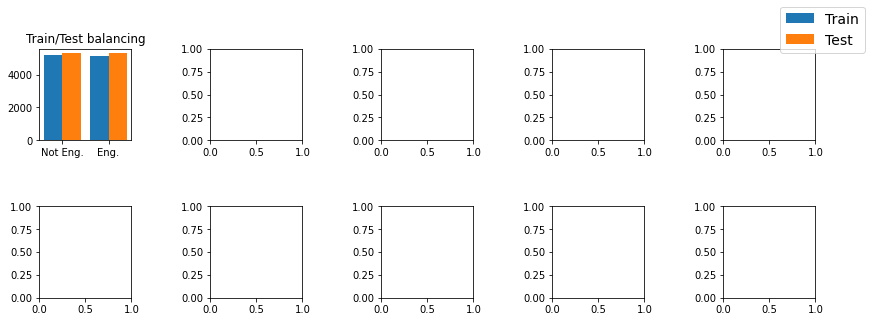

In [15]:
f, a = plt.subplots(2, 5)
a = a.ravel()

f.set_figheight(10*0.5)
f.set_figwidth(25*0.5)
f.tight_layout(pad=4.5)

a[0].set_title('Train/Test balancing')

# Histogram of data per class in train dataset
tmpData = np.asarray(train_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData,
         align='edge', width=-0.4, label="Train")

# Histogram of data per class in test dataset
tmpData = np.asarray(test_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData, align='edge', width=0.4, label="Test")

f.legend(fontsize=14)


In [16]:
procLog.info(allFitResults_A[-1].history)

{'loss': [0.38510096073150635, 0.31130391359329224, 0.26187101006507874, 0.22738222777843475, 0.20066742599010468, 0.18094047904014587, 0.16680563986301422, 0.15543603897094727, 0.14482031762599945, 0.1386258453130722, 0.1318770796060562, 0.12436146289110184], 'accuracy': [0.8298631906509399, 0.8636749982833862, 0.8869379758834839, 0.9028651118278503, 0.9158362150192261, 0.9271957874298096, 0.9335231781005859, 0.9382884502410889, 0.9440324902534485, 0.946138322353363, 0.9495689272880554, 0.9525052309036255], 'val_loss': [0.3990761637687683, 0.35377398133277893, 0.3177545666694641, 0.2912243604660034, 0.3036244809627533, 0.2913385331630707, 0.2825189530849457, 0.30561503767967224, 0.2961125671863556, 0.3033897578716278, 0.3325473964214325, 0.3264084458351135], 'val_accuracy': [0.7927461266517639, 0.8216674327850342, 0.8440885543823242, 0.8454074263572693, 0.8536975979804993, 0.8486104607582092, 0.8699952960014343, 0.8461610674858093, 0.8635892868041992, 0.8613283038139343, 0.85435706377